#**Bitcoin Predictions with ARIMA**

In [1]:
#importing libraries for dataframe and mathematical functions
import pandas as pd
from pandas import DataFrame
import numpy as np

#importing libraries for graphical representation
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import seaborn as sns

#imported library for date,time variables
from datetime import datetime, timedelta

#importing libraries necessary for model creation
from statsmodels.tsa.arima_model import ARIMA                 #library for ARIMA model implementation
from statsmodels.tsa.statespace.sarimax import SARIMAX        #library for SARIMAX model implementation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #library imported for plotting ACG and PACF graphs
from statsmodels.tsa.stattools import adfuller                #library to compute with ADFuller test

#importing library for seasonal decomposition implementation
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

#**Data Collection and Pre-processing**

In [2]:
# need to extract data of bitcoin data only[1]
bc =  pd.read_csv('data folder/KDSH Data/btc_15m.csv')# dropping all the columns that are not necessary for the predictions work[1]

column_mapping = {
        'datetime': 'Date',
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'volume': 'Volume'
    }
bc.rename(columns=column_mapping ,inplace=True)



bc['Date'] = pd.to_datetime(bc['Date'])
bc.set_index('Date',inplace=True)

In [33]:
bc.head()

In [4]:
#resampling the data into monthly frequency[3]

# This will produce a new DataFrame 'bc_mth' where the data from 'bc' has
# been aggregated at the monthly level by taking the mean.








bc_mth = bc.resample('M').mean()

In [5]:
len(bc_mth)

49

#**Model Pre-processing**

## Stationarity check

Augmented Dickey Fuller(ADF) test result: p = 0.981606 


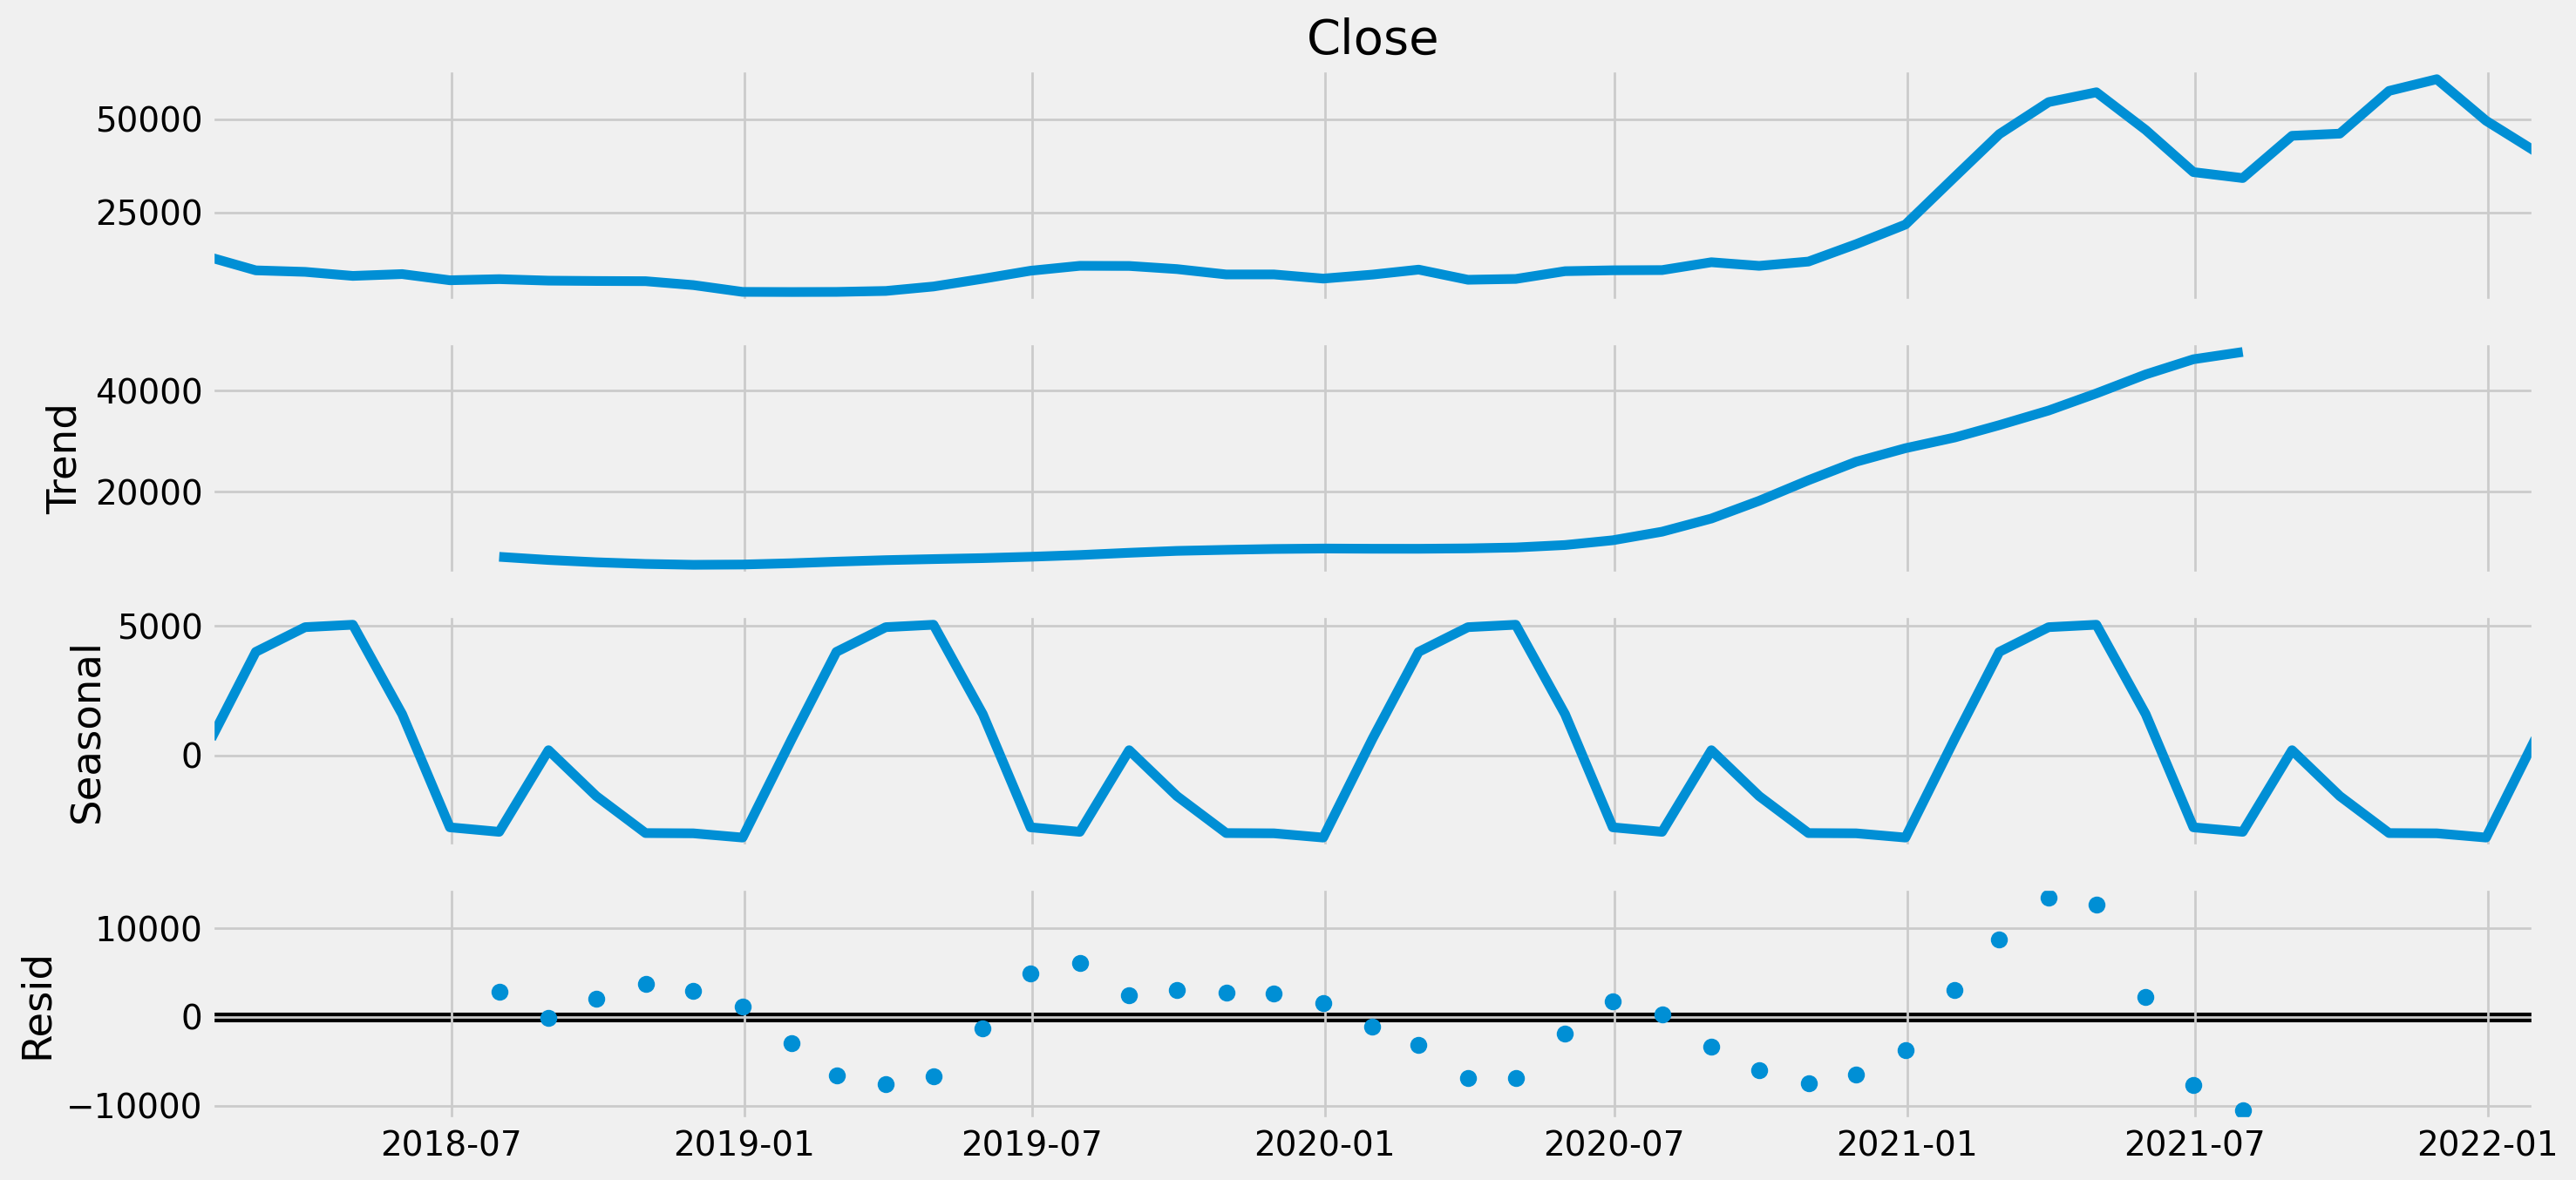

In [6]:
#first step towards model preprocessing phase
#as the seasonal_decompose library has been imported
#will be utilizing it for graphical representation of decomposition
seasonal_decompose(bc_mth['Close']).plot() #[3]
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p = %f " % adfuller(bc_mth['Close'])[1])
plt.show()

As we know that value of p should not be greater than 0.05 for the series to be stationary. But since the p value is 0.97 which is greater than threshold. It can be said that the series is not stationary.

## Box-Cox Transformation

In [7]:
# implementing Box-Cox Transformations for normalization [3]
bc_mth['close_box'], lmbda = stats.boxcox(bc_mth['Close'])
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p =%f" % adfuller(bc_mth.close_box)[1])

Augmented Dickey Fuller(ADF) test result: p =0.829784


The series is still not stationary.

## Differencing

### Seasonal differentiation

In [8]:
# creating new dataframe to compute monthly seasonal differentition for 12 months [3]
bc_mth['box_diff_seasonal_12'] = (bc_mth.close_box - bc_mth.close_box.shift(12))
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p = %f" % adfuller(bc_mth.box_diff_seasonal_12[12:])[1])

Augmented Dickey Fuller(ADF) test result: p = 0.059530


Series is still not stationary.




In [9]:
#creating new dataframe to compute monthly seasonal differentition for 3 months [3]
bc_mth['box_diff_seasonal_3'] = bc_mth.close_box - bc_mth.close_box.shift(3)
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p = %f" % adfuller(bc_mth.box_diff_seasonal_3[3:])[1])

Augmented Dickey Fuller(ADF) test result: p = 0.004560


The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05.

### Regular differentiation

To obtain a stationary time series, it may be necessary to difference the data a second time, which is known as second order differencing.

Augmented Dickey Fuller(ADF) test result: p = 0.045766


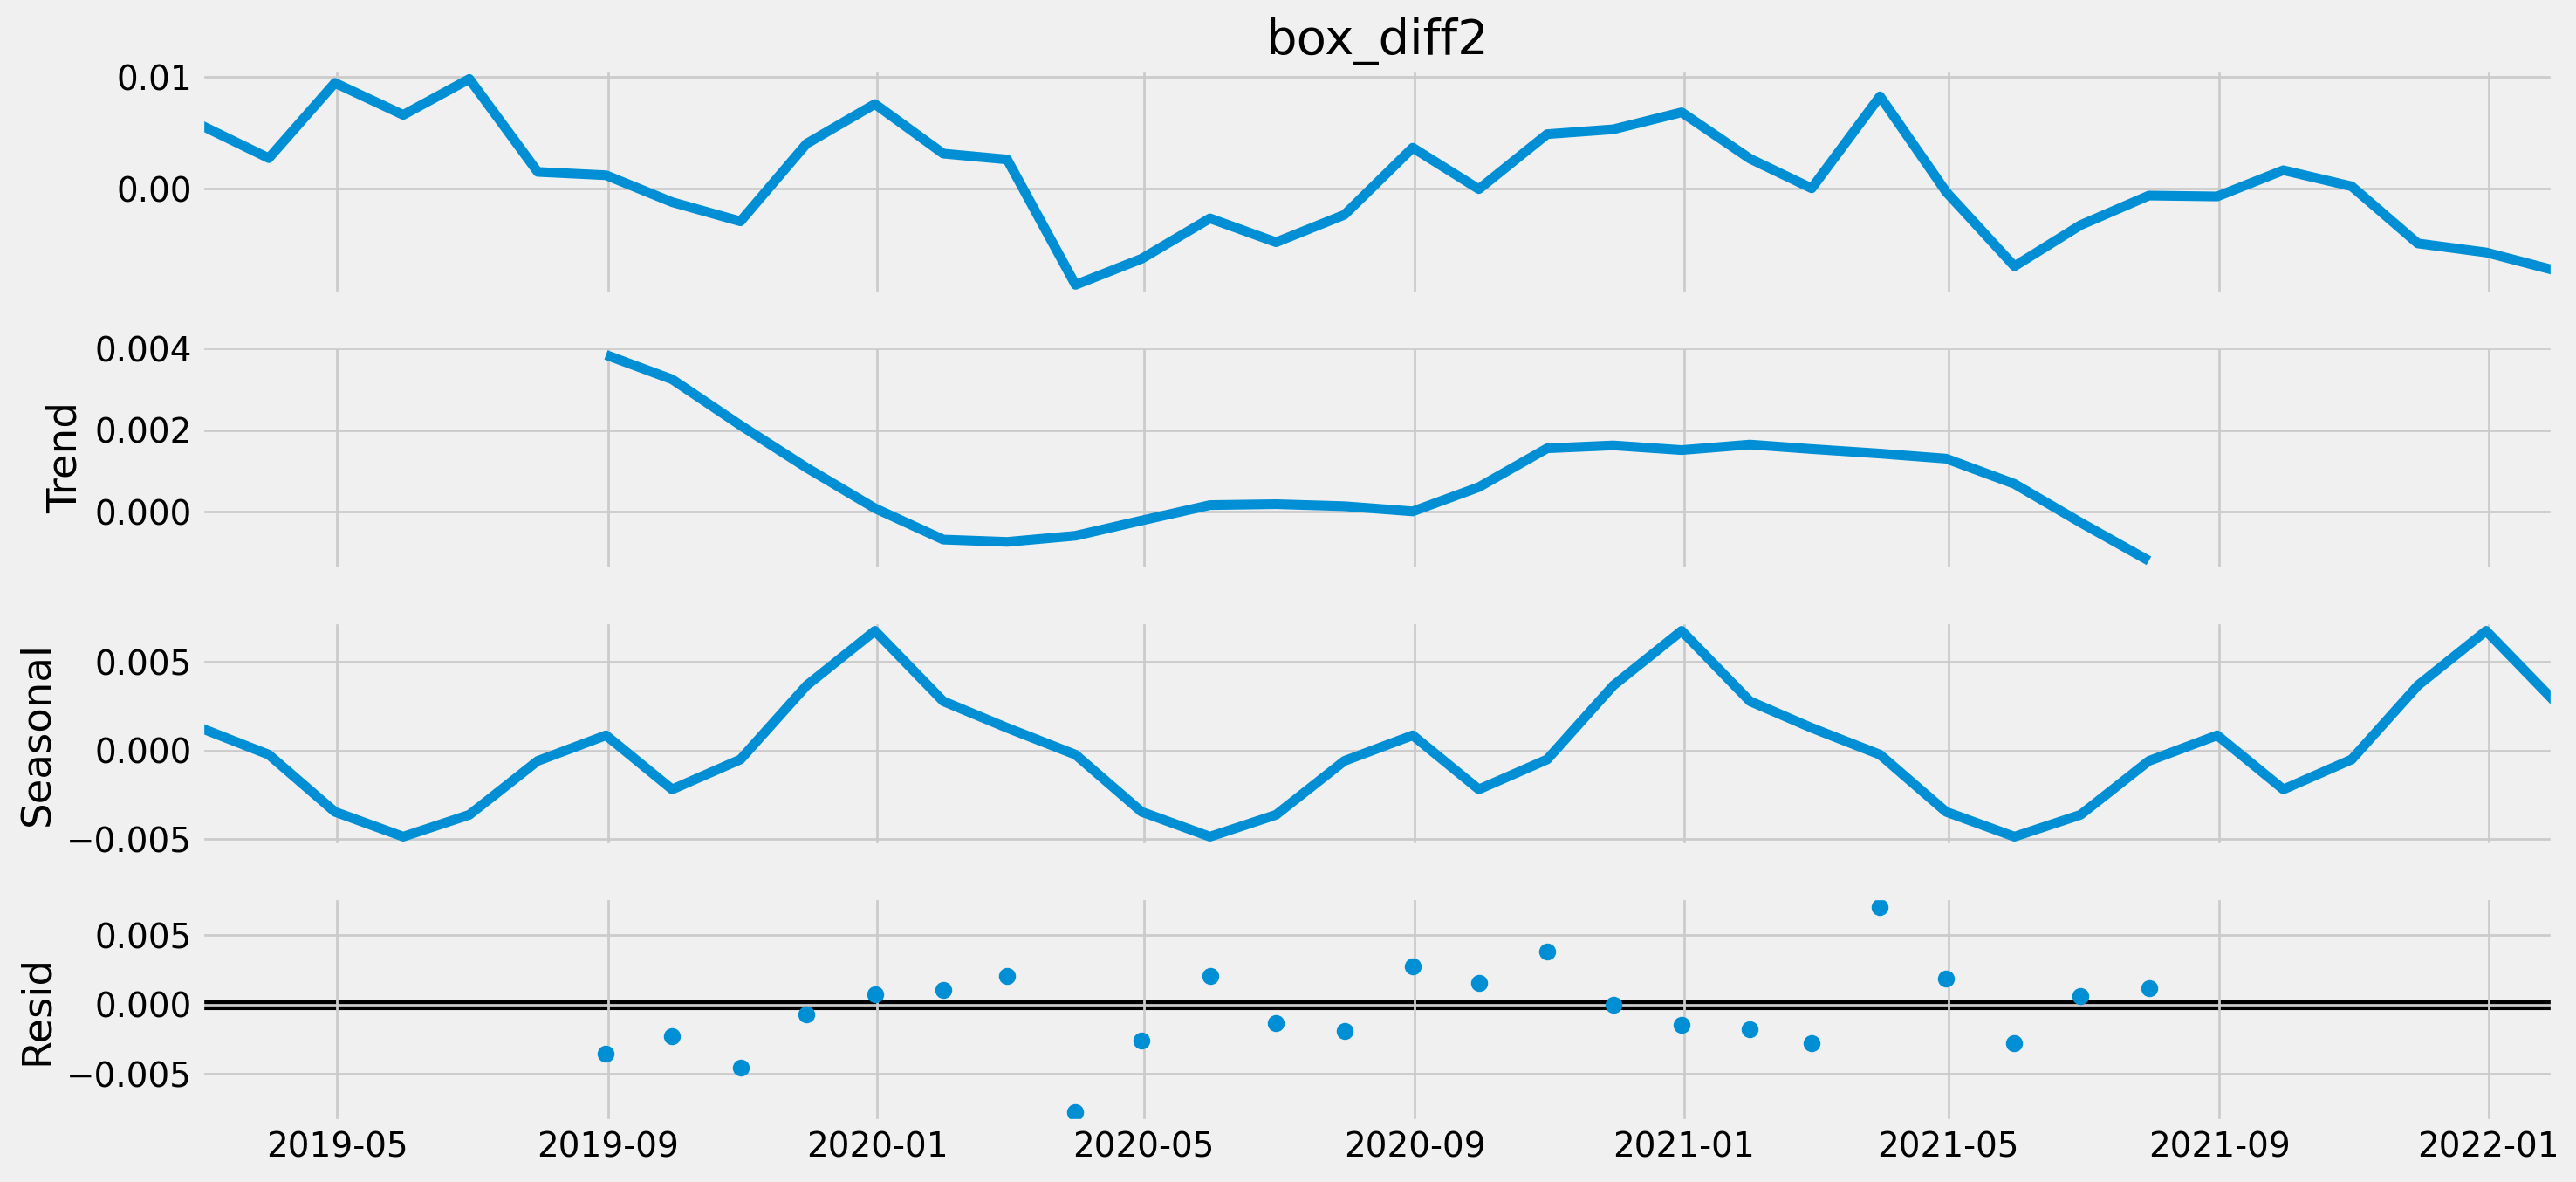

In [10]:
# #creating new dataframe to compute implement differentition for 12 months [3]
bc_mth['box_diff2'] = (bc_mth.box_diff_seasonal_12 - bc_mth.box_diff_seasonal_12.shift(1))

# Seasonal and Trend decomposition using Loess decomposition [3]
seasonal_decompose(bc_mth.box_diff2[13:]).plot()   
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p = %f" % adfuller(bc_mth.box_diff2[13:])[1])

plt.show()

The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05. 

### Autocorrelation

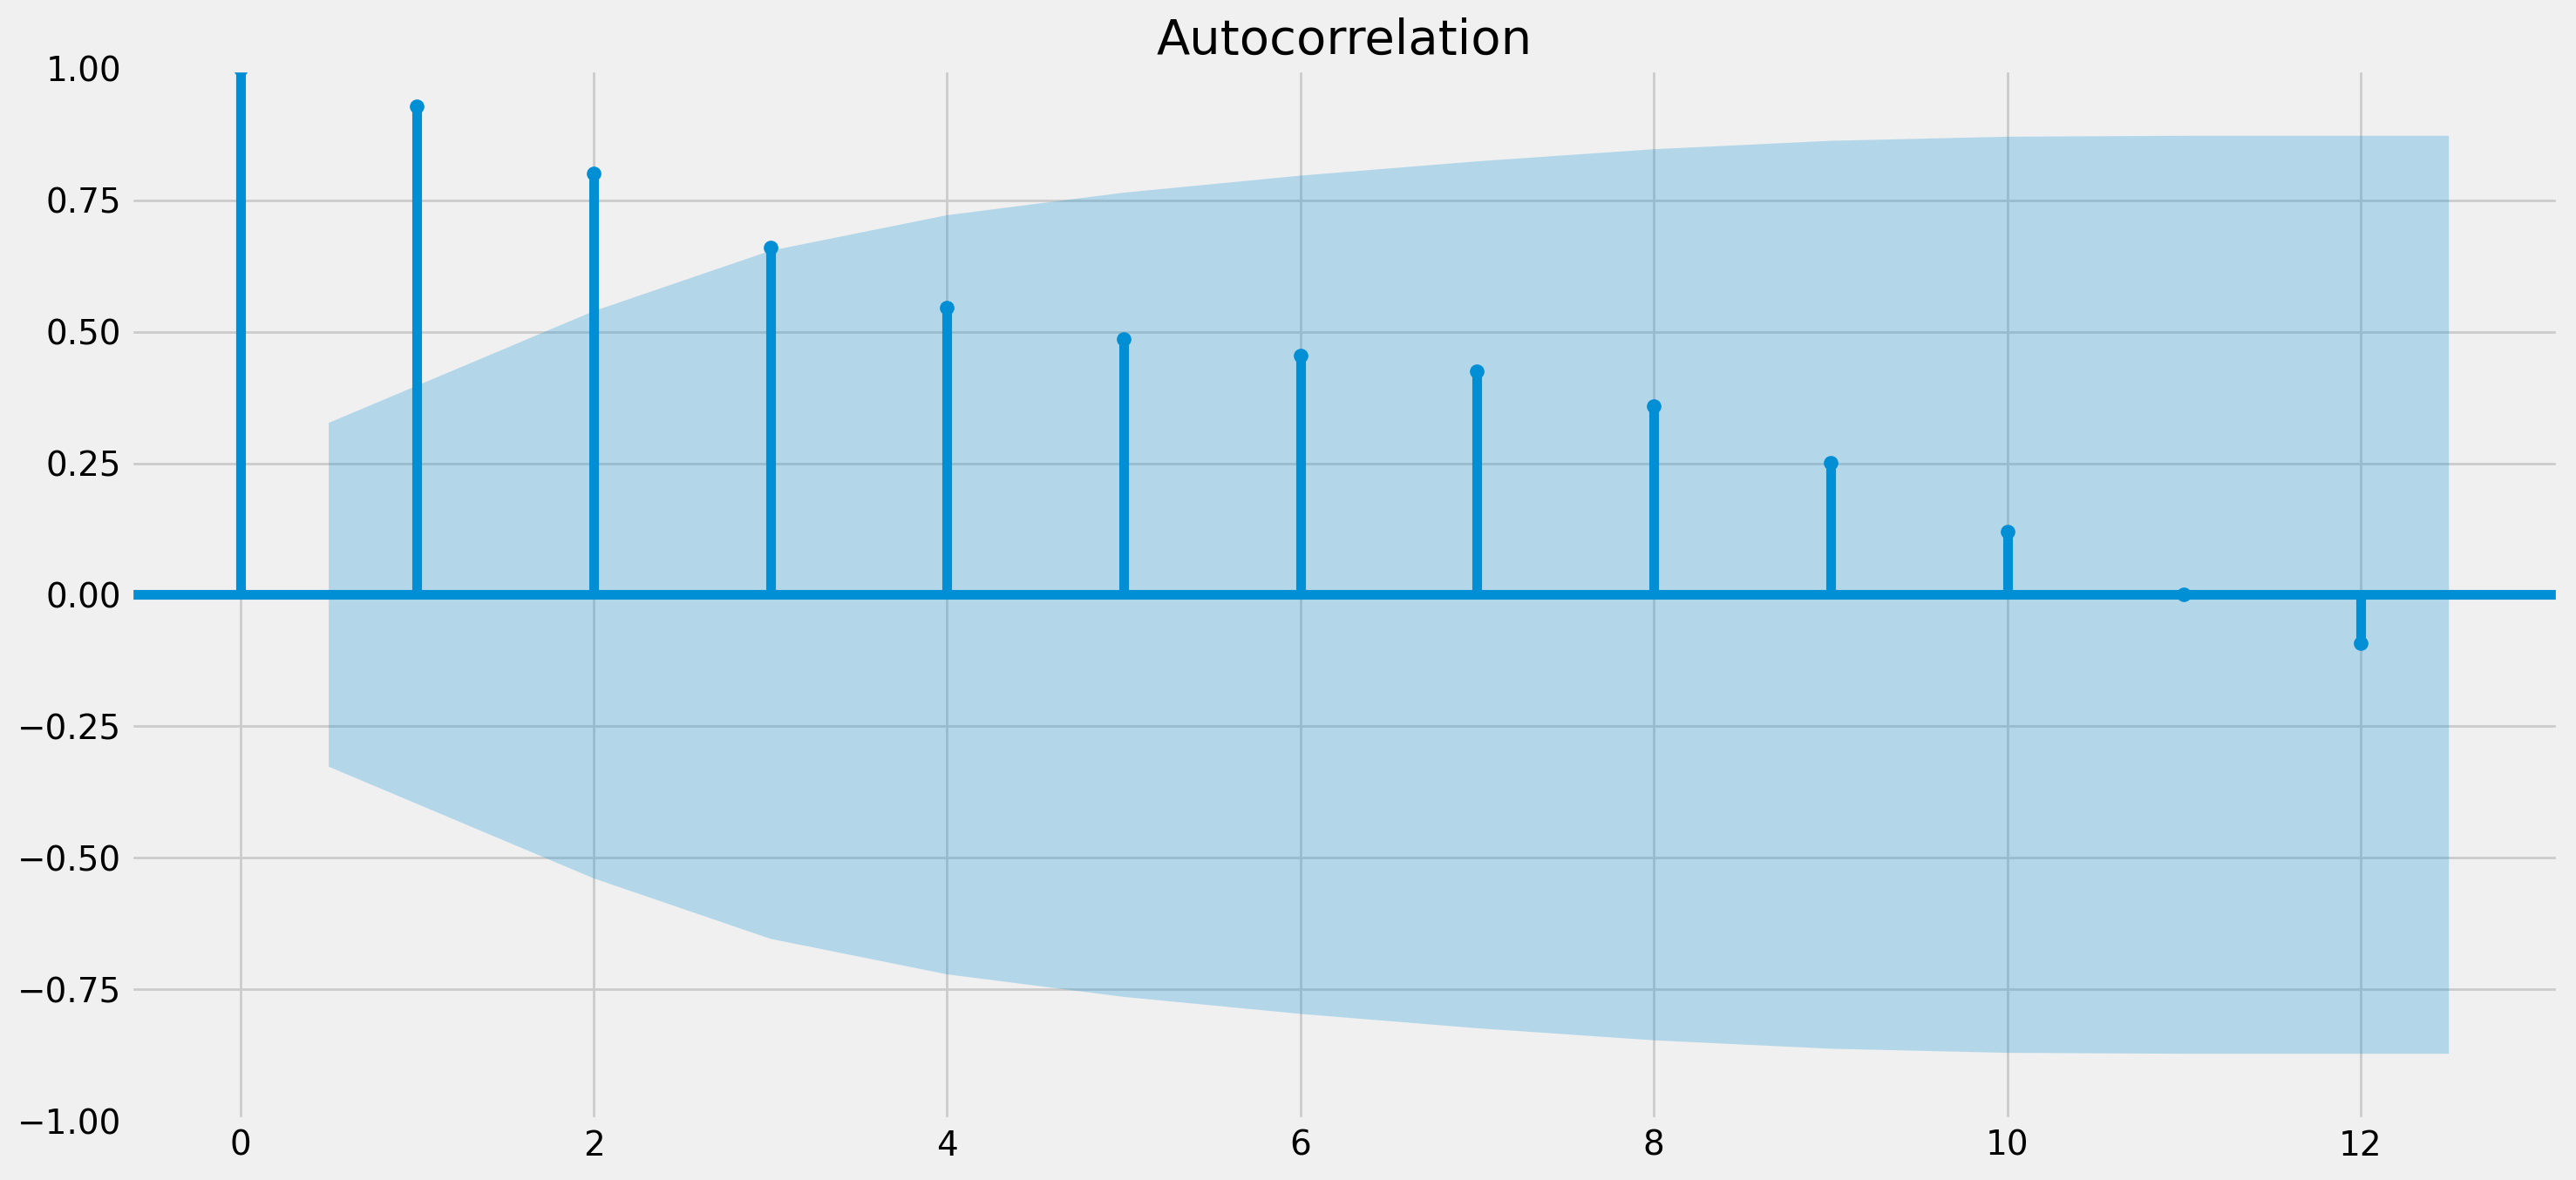

In [11]:
#plotting ACF graph to check for AR value autocorrelation_plot(bc_mth.close) [3]
plot_acf(bc_mth['Close'][13:].values.squeeze(), lags=12)

plt.tight_layout()
plt.show()

A positive correlation exists with the first 10 lags, which is possibly significant for the first 2-3 lags.

A good starting point for the model's AR parameter is 3.

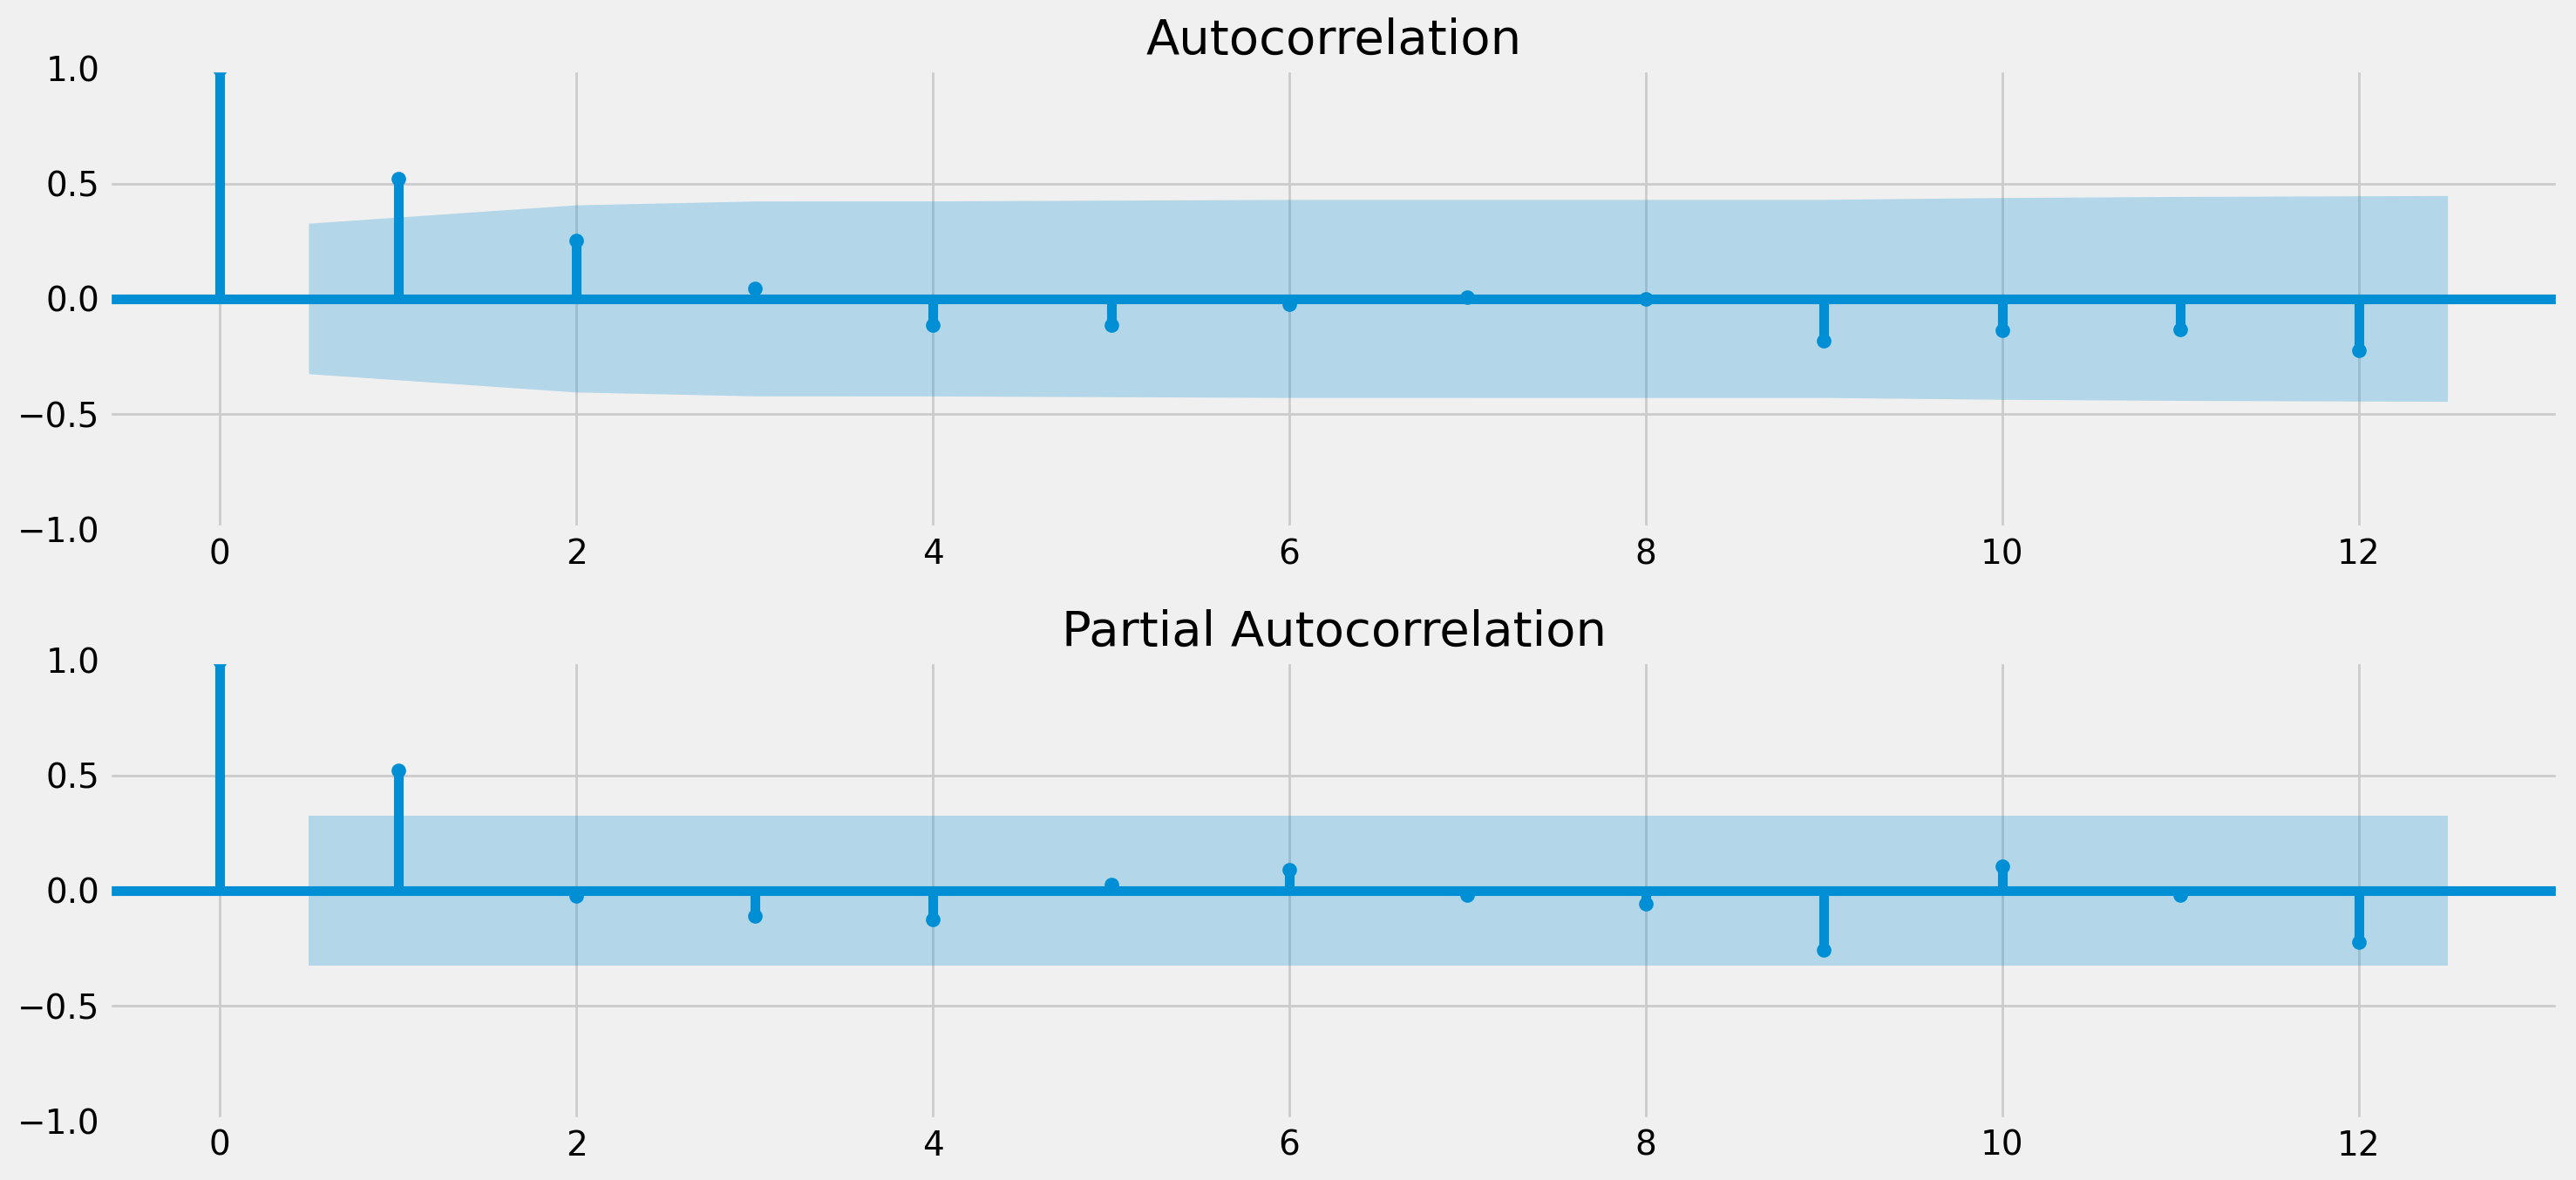

In [12]:
# Initial parameter approximation 
#PlottingAutocorrelation(ACF) and Partial Autocorrelation(PACF) Plots[3]
ax = plt.subplot(211)
# Plot the autocorrelation function [3]
plot_acf(bc_mth.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#plotting ACF graph to check for AR value autocorrelation_plot(bc_mth.close) [3]
plot_pacf(bc_mth.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

# **Model Building**

##ARIMA Model
AutoRegressive Integrated Moving Average

#### Parameter Selection


In [13]:
#Model building phase
#building ARIMA model
# Initial parameter approximation[1]
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# selecting appropriate model based on (p,d,1) parameters[3]
rslt = []
aic_bst = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(bc_mth.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('poor combination of parameters:', param)
        continue
    aic = model.aic
    if aic < aic_bst:
        mdl_bst = model
        aic_bst = aic
        params_bst = param
    rslt.append([param, model.aic])

In [14]:
#printing the best suited results of the models[1]
#new dataframe to store the results of the appropriate models
rslt_table = pd.DataFrame(rslt)
#creating two columns to print values accordingly
rslt_table.columns = ['parameters', 'aic']
#sorting of values based into the relevant columns
print(rslt_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
3     (1, 0) -411.358164
1     (0, 1) -410.514307
6     (2, 0) -409.396968
4     (1, 1) -409.379216
2     (0, 2) -407.774060


In [15]:
#representation of summary of appropriate ARIMA models[1]
print(mdl_bst.summary())

                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   49
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 207.679
Date:                Thu, 11 Jan 2024   AIC                           -411.358
Time:                        14:36:40   BIC                           -407.616
Sample:                    01-31-2018   HQIC                          -409.944
                         - 01-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3841      0.129      2.982      0.003       0.132       0.637
sigma2      1.018e-05   2.01e-06      5.076      0.000    6.25e-06    1.41e-05
Ljung-Box (L1) (Q):                   0.01   Jarque-

### Analysis of Results

In [16]:
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result:: p=%f" % adfuller(mdl_bst.resid[13:])[1])

Augmented Dickey Fuller(ADF) test result:: p=0.092161


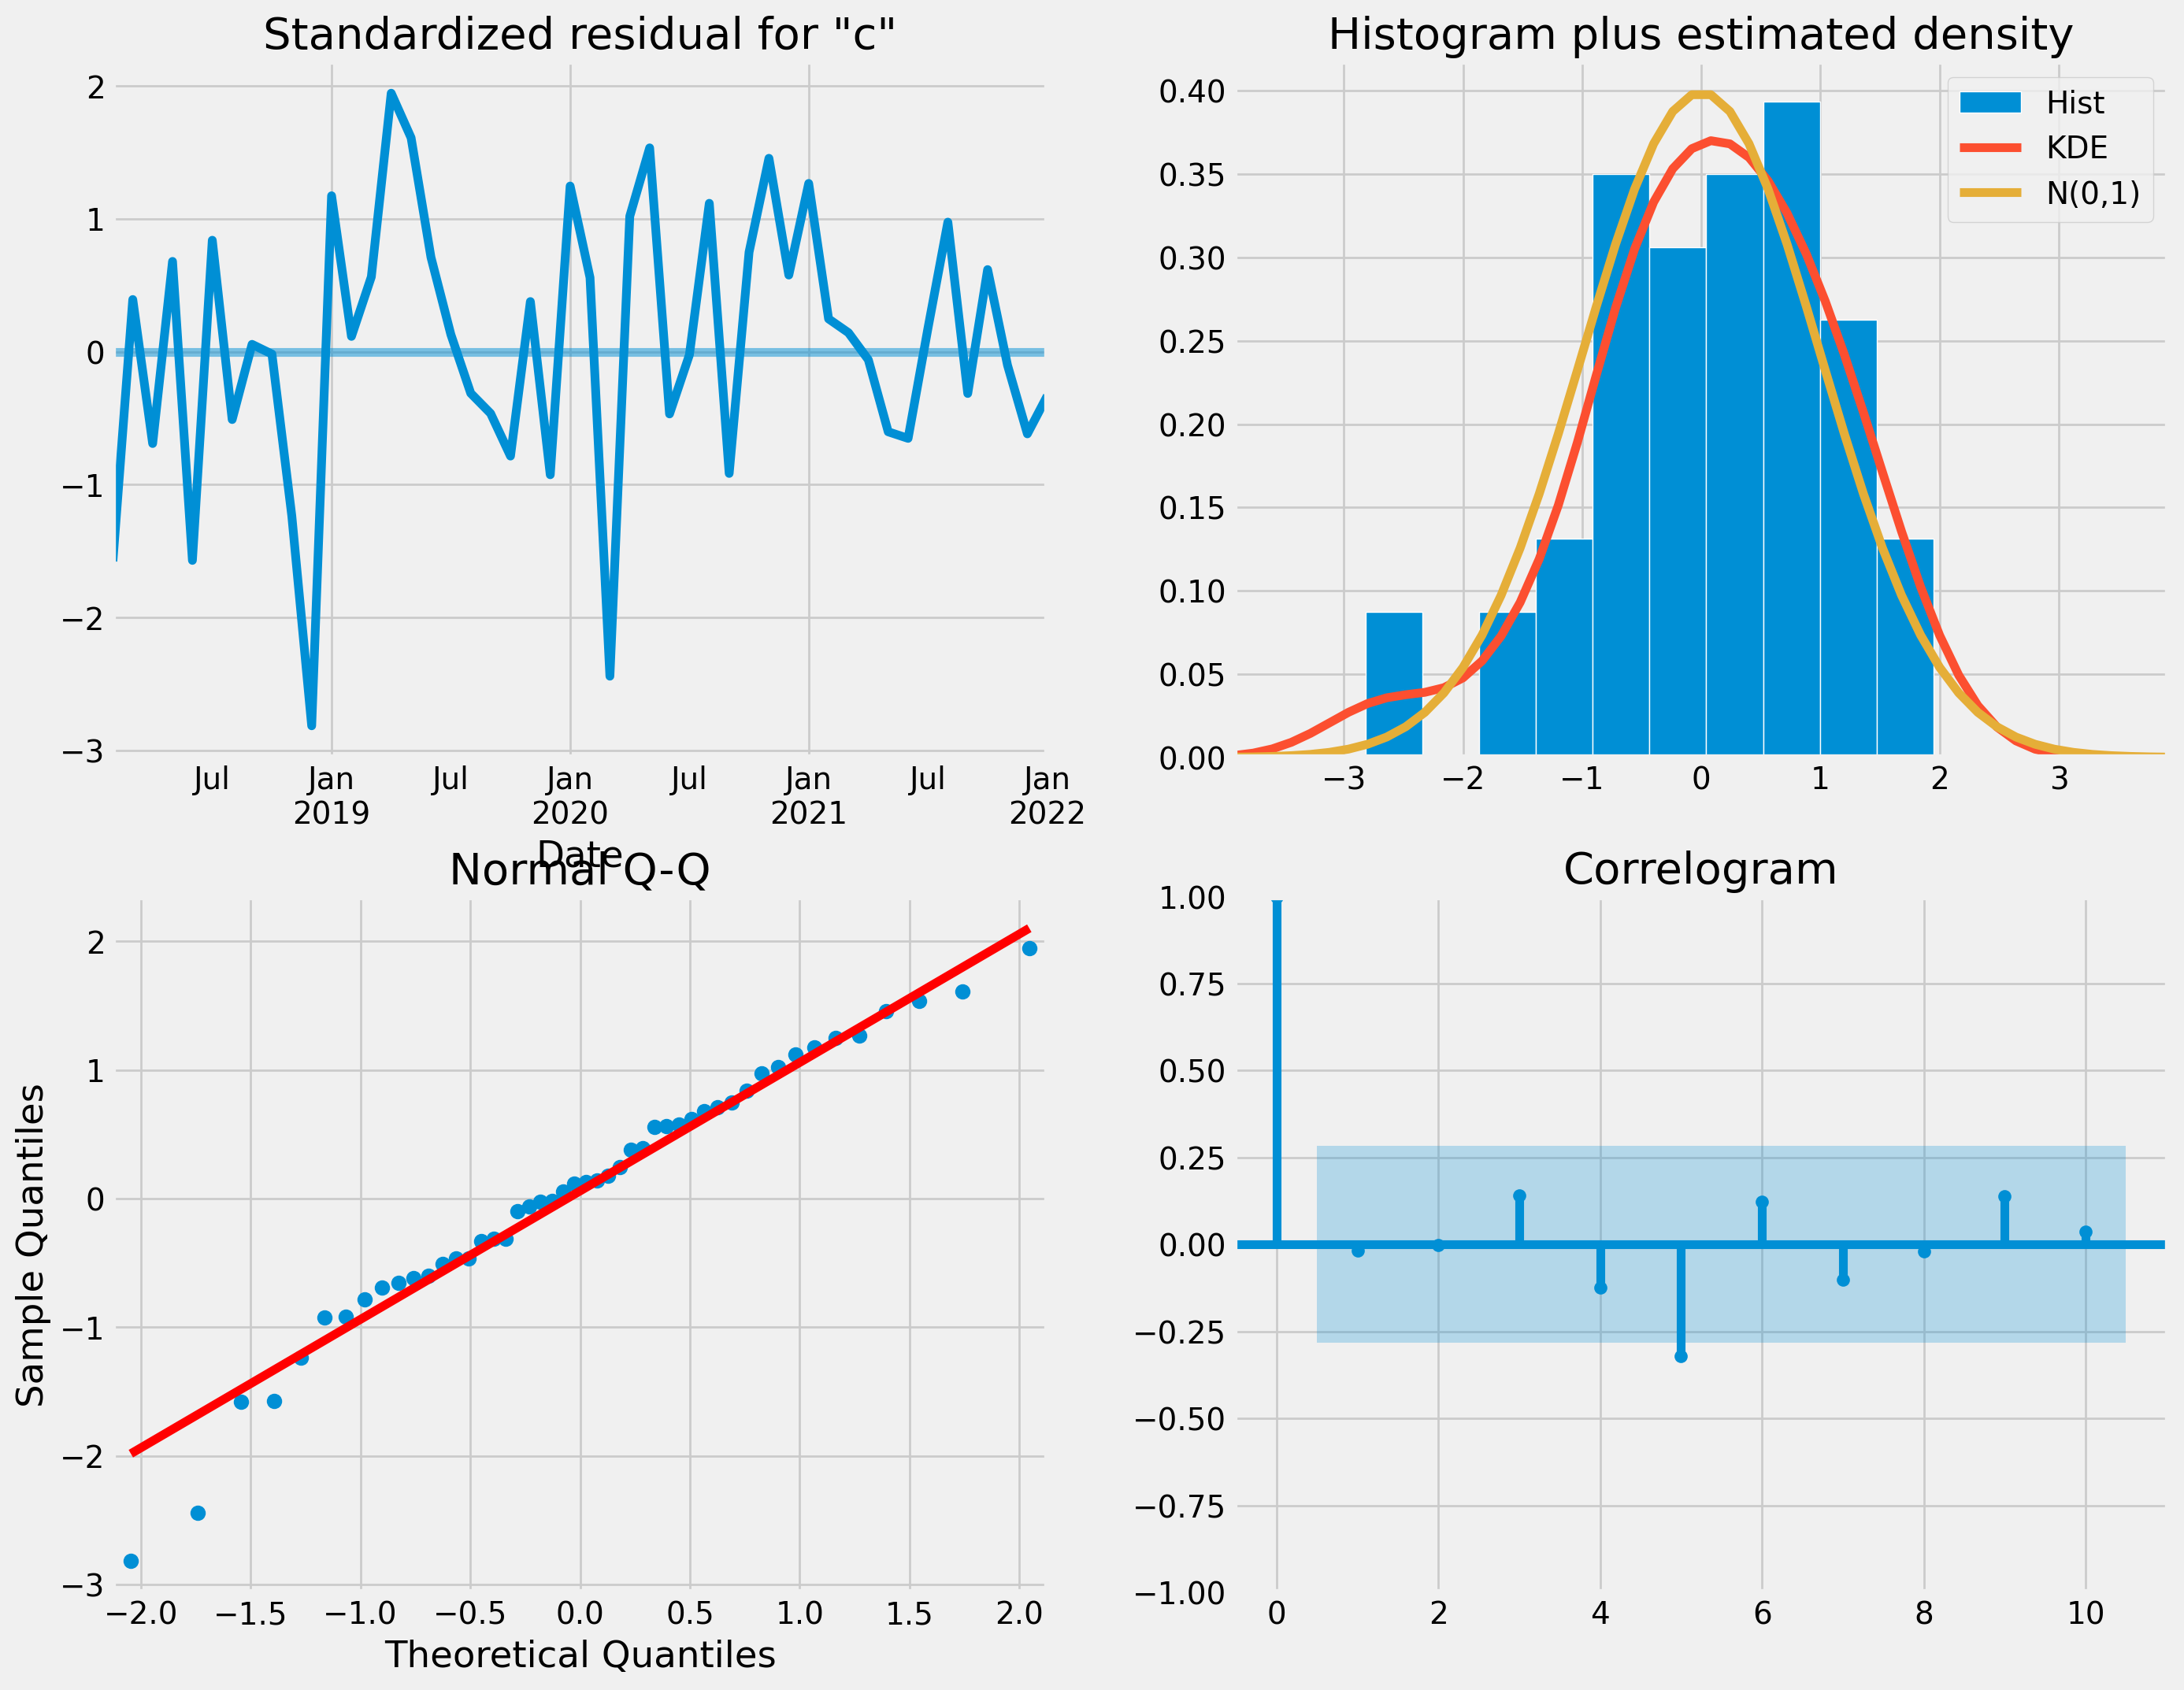

In [17]:
#running the model diagnostics functions and plotting its result [3]
mdl_bst.plot_diagnostics(figsize=(15, 12))
plt.show()

###Predictions

In [18]:
#using inverse Box-Cox transformation function[3]
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [19]:
bc

Open      High       Low     Close      Volume
Date                                                                   
2018-01-01 05:30:00  13715.65  13715.65  13400.01  13556.15  123.616013
2018-01-01 05:45:00  13533.75  13550.87  13402.00  13521.12   98.136430
2018-01-01 06:00:00  13500.00  13545.37  13450.00  13470.41   79.904037
2018-01-01 06:15:00  13494.65  13690.87  13450.00  13529.01  141.699719
2018-01-01 06:30:00  13528.99  13571.74  13402.28  13445.63   72.537533
...                       ...       ...       ...       ...         ...
2022-01-31 04:30:00  37785.78  38230.00  37778.46  38183.74  847.160640
2022-01-31 04:45:00  38183.75  38215.14  37979.66  38060.25  421.248110
2022-01-31 05:00:00  38060.24  38088.44  37875.58  37959.87  288.104410
2022-01-31 05:15:00  37959.87  37959.88  37870.00  37881.76  172.298640
2022-01-31 05:30:00  37881.75  37951.07  37656.89  37707.47  483.564600

[142610 rows x 5 columns]

In [20]:
# predicting prices of Bitcoin's close values[3]
#storing the predictions into a new dataframe
bc_mth_pred = bc_mth[['Close']]
#creating a list of dates to predict prices for a particular range
date_list = [
    datetime(2022, 2, 28),
    datetime(2022, 4, 30),
    datetime(2022, 5, 31),
    datetime(2022, 6, 30),
    datetime(2022, 7, 31),
    datetime(2022, 8, 31),
    datetime(2022, 9, 30),
    datetime(2022, 10, 31),
    datetime(2022, 11, 30),
    datetime(2022, 12, 31)
]
#date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
#new dataframe with stored predictions over a period of time
future = pd.DataFrame(index=date_list, columns= bc_mth.columns)
bc_mth_pred = pd.concat([bc_mth_pred, future])

#monthly forecasting of the values of Bitcoin's close prices
bc_mth_pred['forecast'] = invboxcox(mdl_bst.predict(start=0, end=75), lmbda)
# bc_mth_pred['forecast'] = invboxcox(mdl_bst.predict(start=datetime(2014, 1, 31), end=datetime(2018, 6, 30)), lmbda)


import plotly.graph_objects as go

# Assuming bc_mth_pred is a DataFrame containing 'Close' and 'forecast' columns

fig = go.Figure()

# Adding the 'Close' trace
fig.add_trace(go.Scatter(x=bc_mth_pred.index, y=bc_mth_pred['Close'], mode='lines', name='Close'))

# Adding the 'forecast' trace with red dashed line style
fig.add_trace(go.Scatter(x=bc_mth_pred.index, y=bc_mth_pred['forecast'], mode='lines', line=dict(color='red', dash='dash'), name='Predicted Close'))

# Updating layout
fig.update_layout(
    title='Bitcoin Monthly Forecast',
    xaxis=dict(title='Date'),
    yaxis=dict(title='USD')
)

# Display the plot
fig.show()


## SARIMAX Model
Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

#### Parameter Selection

The same process of parameter selection for seasonal ARIMA. For each combination we fit a new seasonal ARIMA model with SARIMAX() and assess its overall quality.

In [21]:
#Model building phase
#building ARIMA model
# Initial parameter approximation[1]
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# selecting appropriate model based on (p,d,1) parameters[3]
# SARIMAX have been tried for different seasonal periods - 12months, 6months, 4months and 3months
rslt = []
aic_bst = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(bc_mth.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#        model = SARIMAX(bc_mth.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 6)).fit(disp=-1)
#        model = SARIMAX(bc_mth.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
#        model = SARIMAX(bc_mth.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 3)).fit(disp=-1) 
    except ValueError:
        print('poor combination of parameters:', param)
        continue
    aic = model.aic
    if aic < aic_bst:
        mdl_bst = model
        aic_bst = aic
        params_bst = param
    rslt.append([param, model.aic])

In [22]:
#printing the best suited results of the models[1]
#new dataframe to store the results of the appropriate models
rslt_table = pd.DataFrame(rslt)
#creating two columns to print values accordingly
rslt_table.columns = ['parameters', 'aic']
#sorting of values based into the relevant columns
print(rslt_table.sort_values(by = 'aic', ascending=True).head())
print(mdl_bst.summary())

      parameters         aic
22  (1, 0, 2, 0) -290.754806
18  (1, 0, 0, 0) -289.568949
20  (1, 0, 1, 0) -289.069648
40  (2, 0, 2, 0) -288.727558
28  (1, 1, 2, 0) -288.369307
                                     SARIMAX Results                                      
Dep. Variable:                          close_box   No. Observations:                   49
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 149.377
Date:                            Thu, 11 Jan 2024   AIC                           -290.755
Time:                                    14:37:24   BIC                           -284.421
Sample:                                01-31-2018   HQIC                          -288.544
                                     - 01-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

### Analysis of Results 

In [23]:
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result:: p = %f" % adfuller(mdl_bst.resid[13:])[1])

Augmented Dickey Fuller(ADF) test result:: p = 0.000000


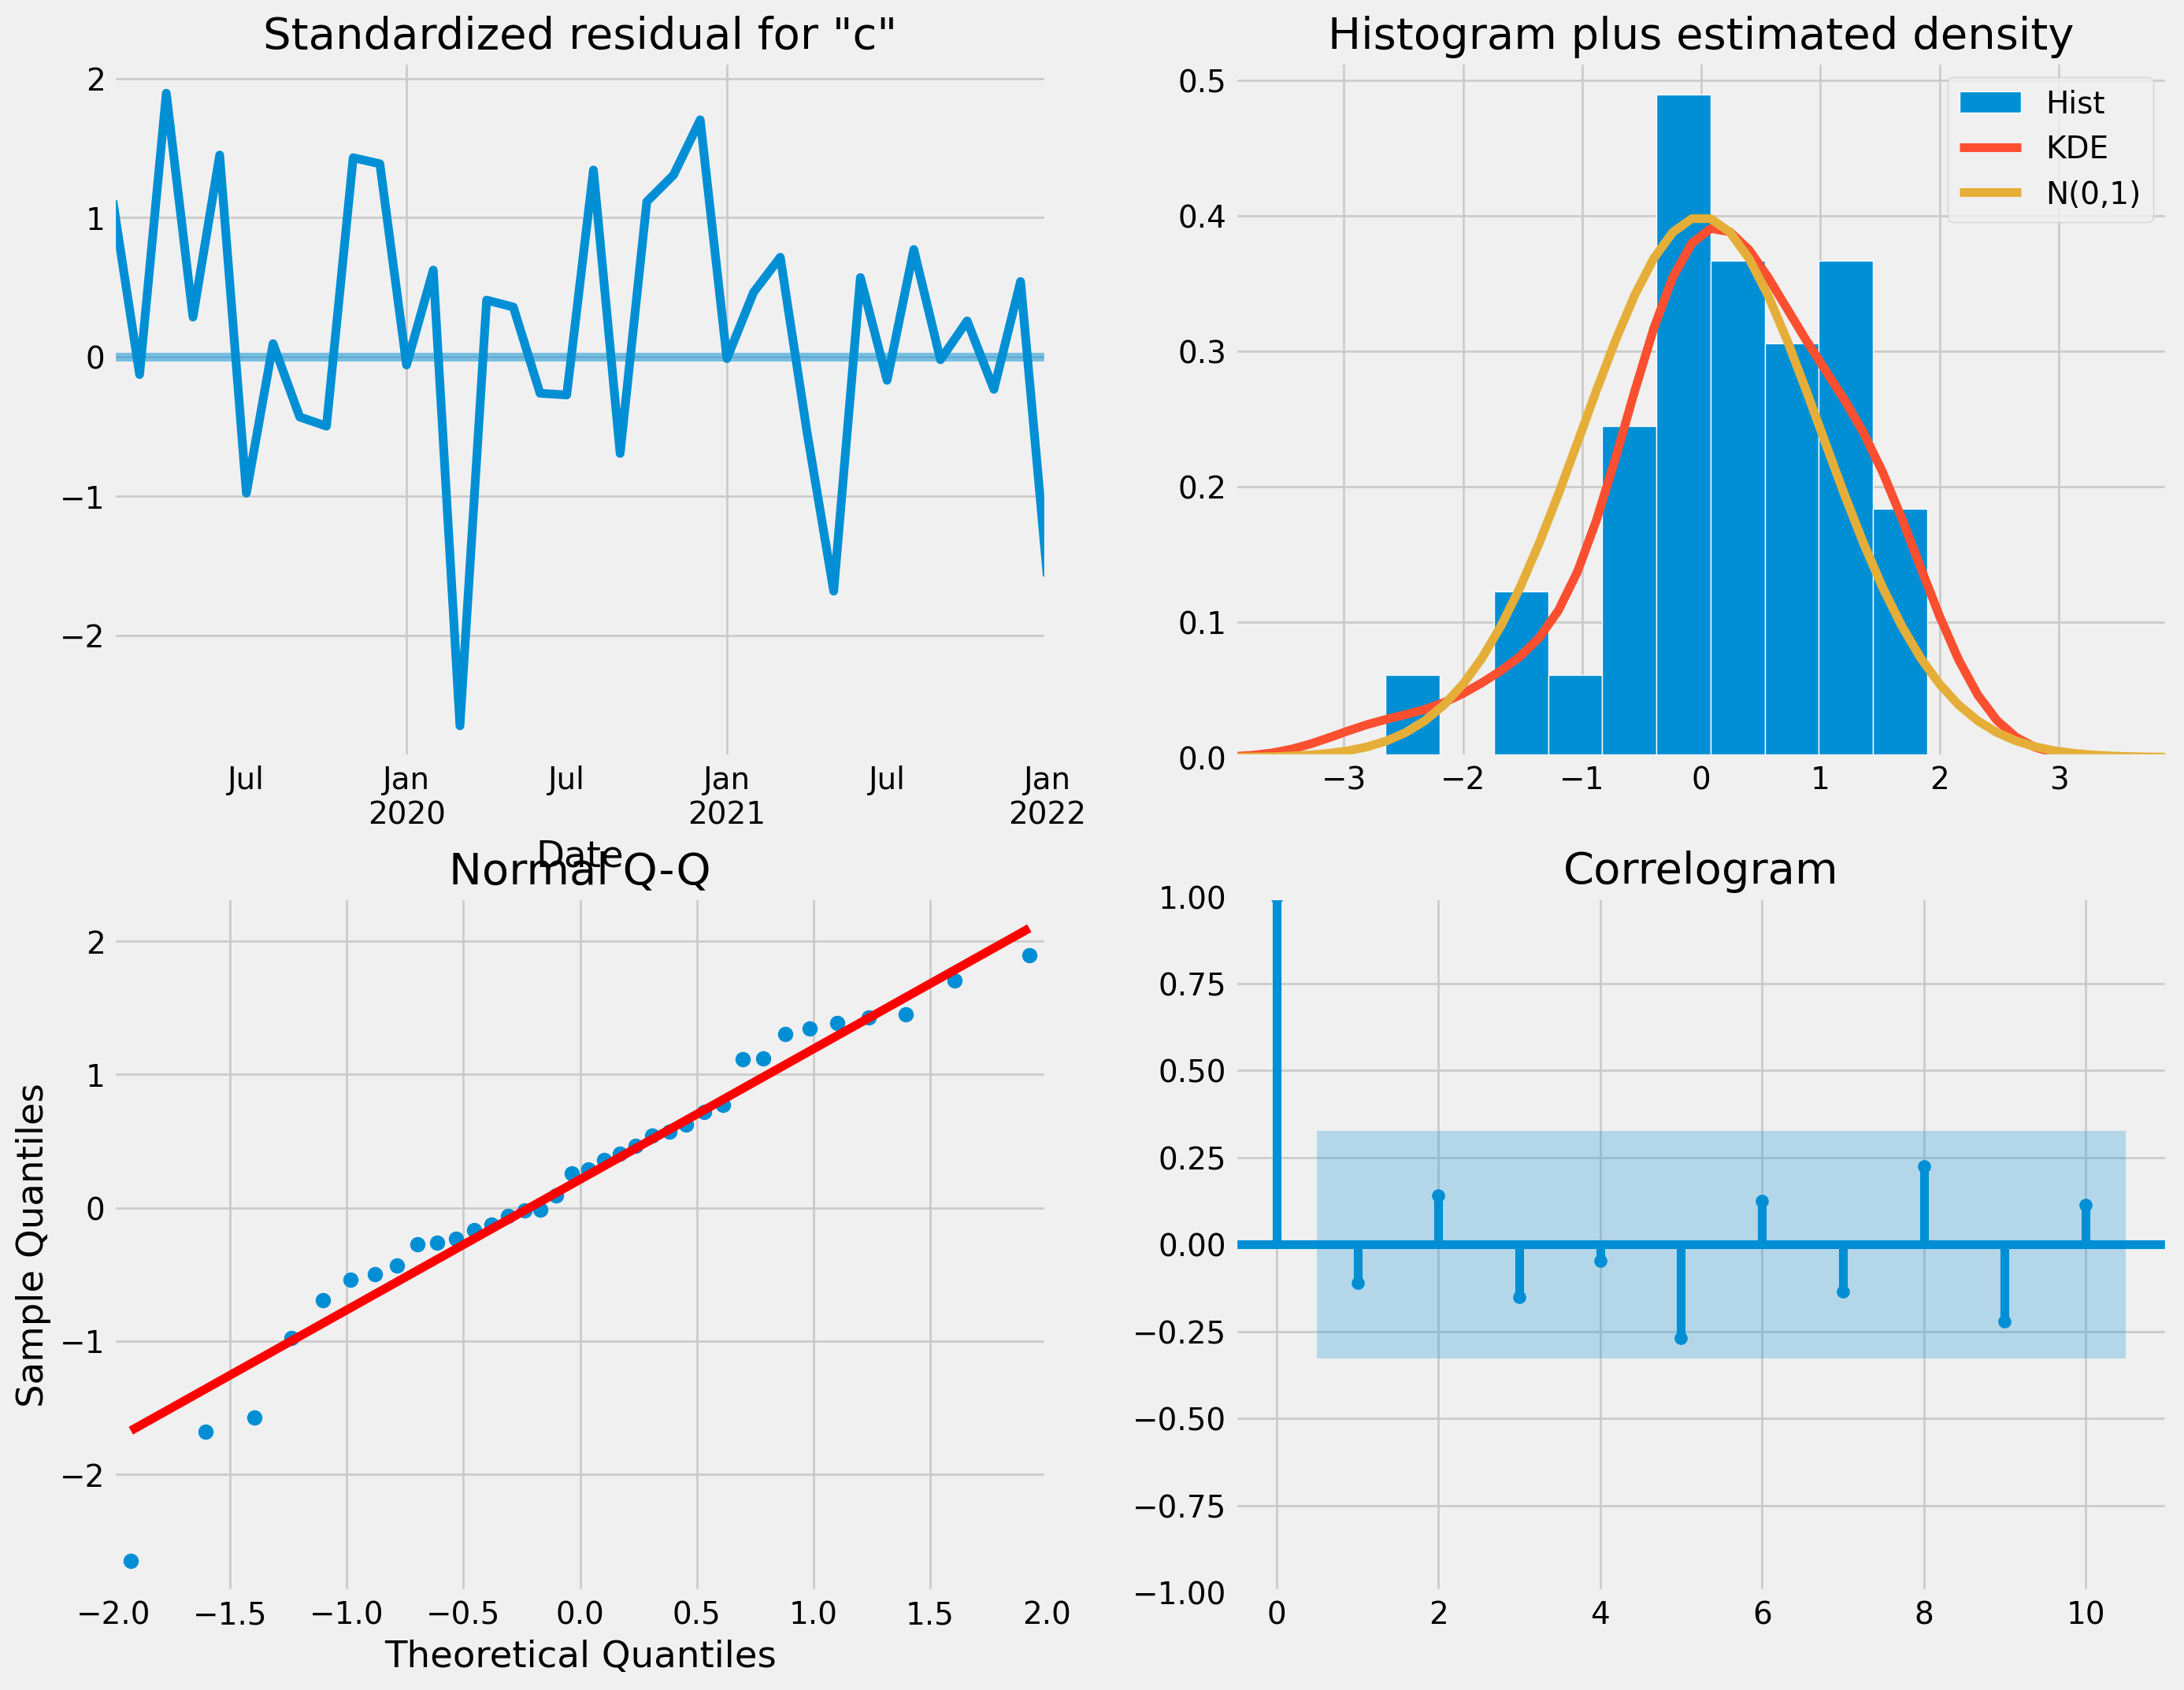

In [24]:
#running the model diagnostics functions and plotting its result [3]
mdl_bst.plot_diagnostics(figsize=(15, 12))
plt.show()

Augmented Dickey Fuller(ADF) test result:: p=0.000000


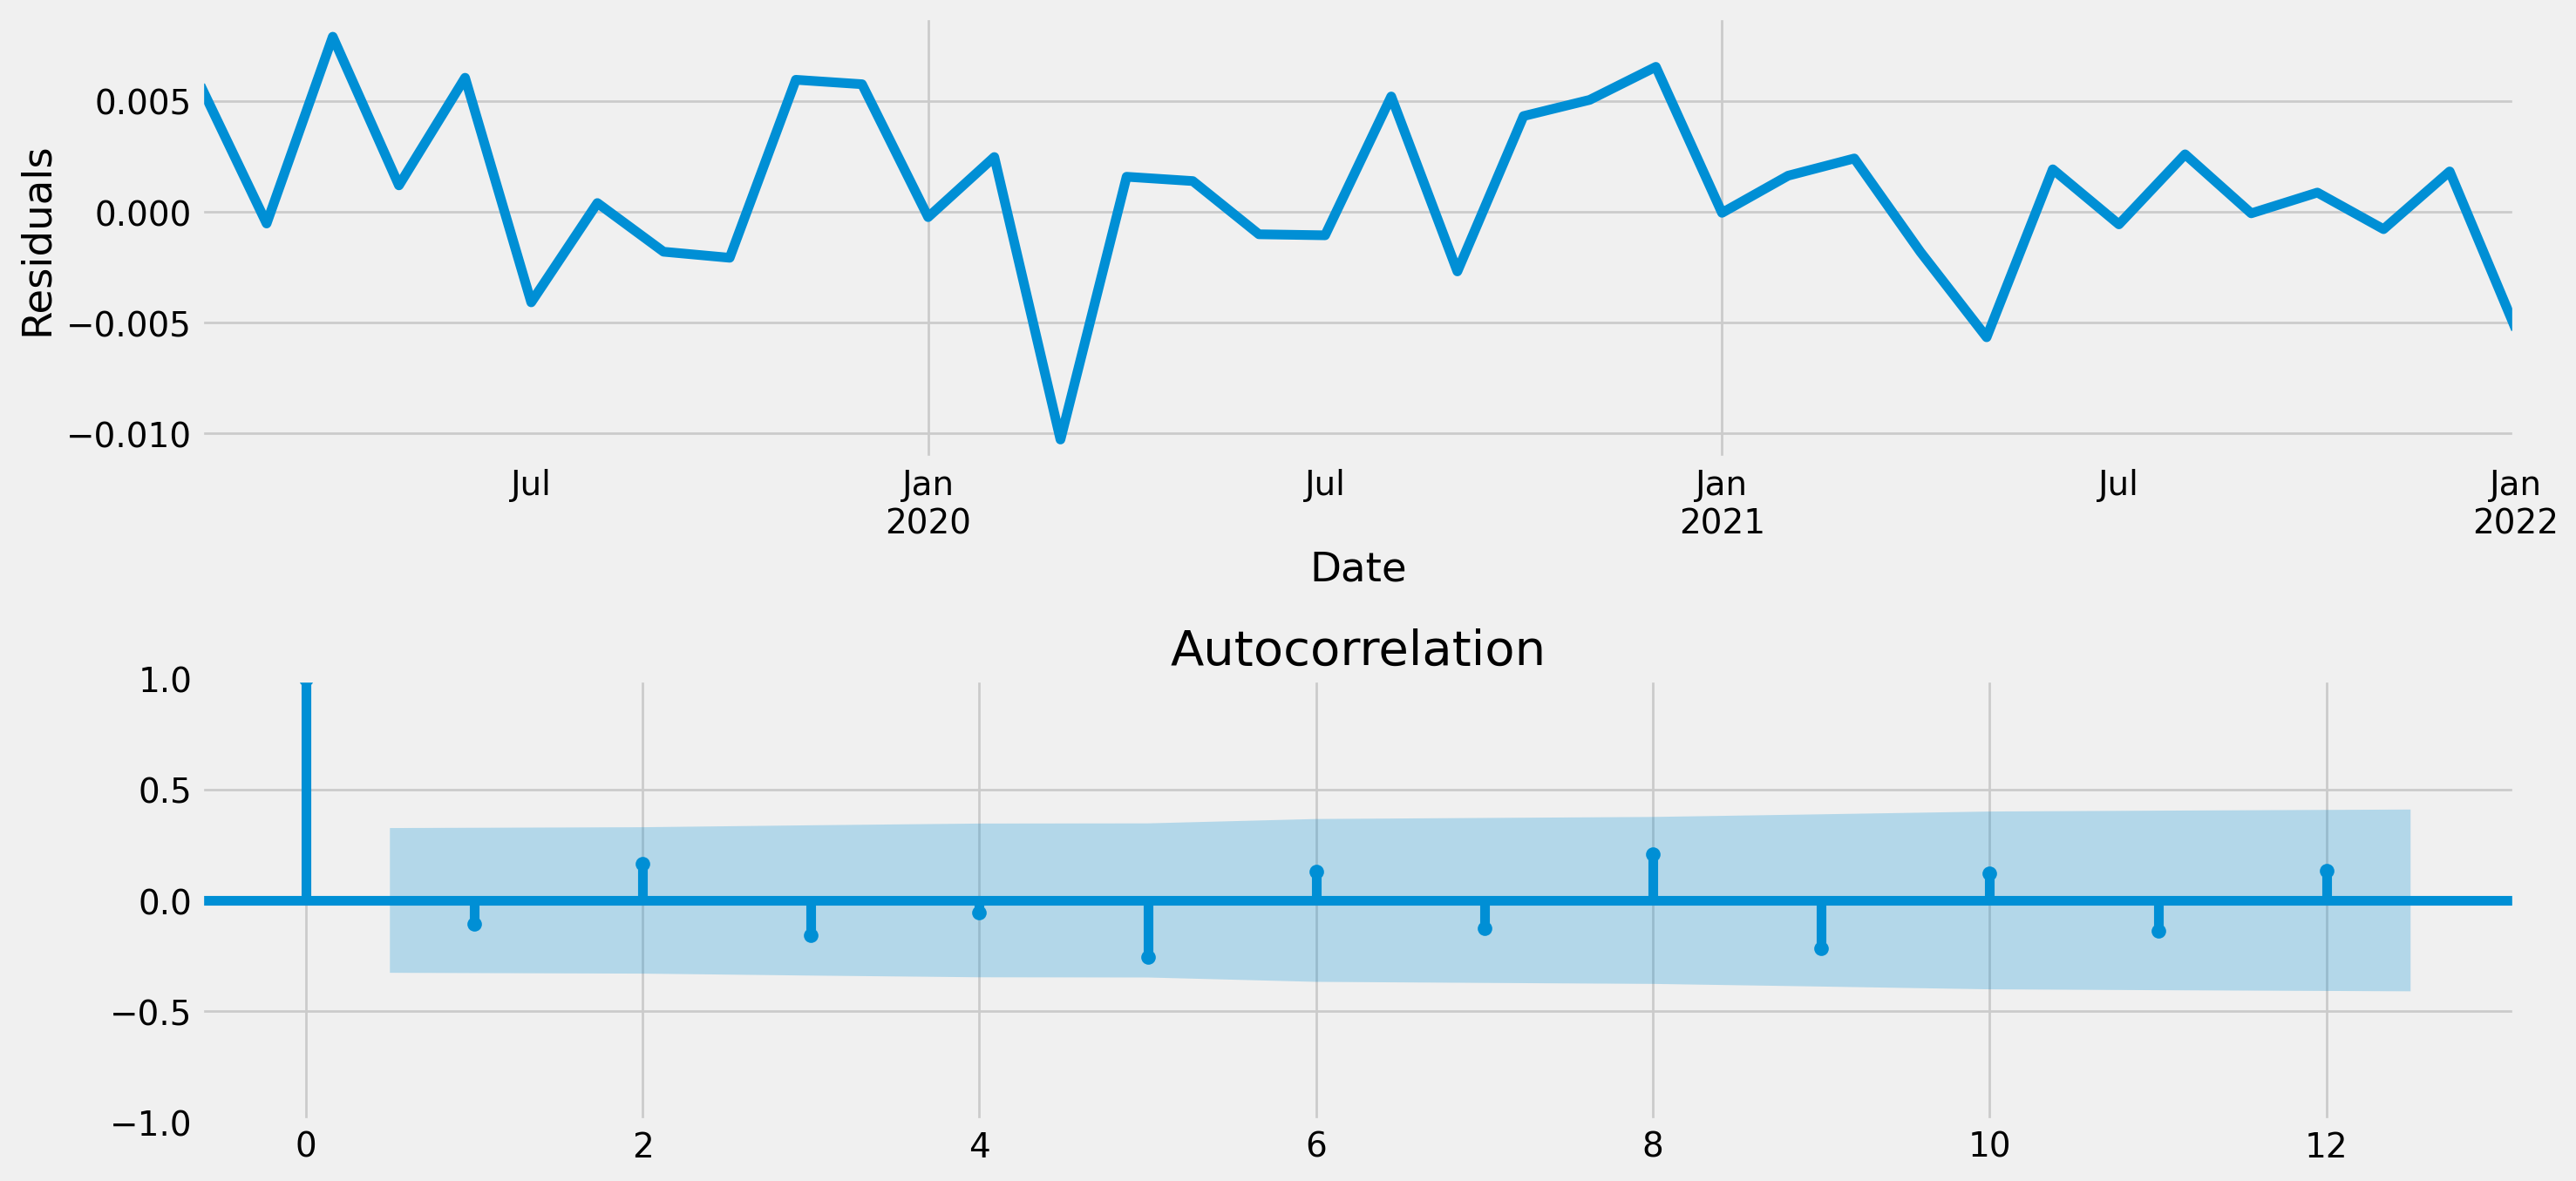

In [25]:
# Seasonal and Trend decomposition using Loess(STL) decomposition[1]
plt.figure(figsize=(15,7))
plt.subplot(211)
mdl_bst.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
plot_acf(mdl_bst.resid[13:].values.squeeze(), lags=12, ax=ax)

#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result:: p=%f" % adfuller(mdl_bst.resid[13:])[1])

plt.tight_layout()
plt.show()

###Prediction

In [26]:
# predicting prices of Bitcoin's close values[3]
#storing the predictions into a new dataframe
# Bitcoin Price Predictions[1]
bc_mth2 = bc_mth[['Close']]
#creating a list of dates to predict prices for a particular range
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]

#new dataframe with stored predictions over a period of time
future = pd.DataFrame(index=date_list, columns= bc_mth.columns)
bc_mth2 = pd.concat([bc_mth2, future])

#monthly forecasting of the values of Bitcoin's close prices
bc_mth2['forecast'] = invboxcox(mdl_bst.predict(start=0, end=75), lmbda)

import plotly.graph_objects as go

# Assuming bc_mth_pred is a DataFrame containing 'Close' and 'forecast' columns

fig = go.Figure()

# Adding the 'Close' trace
fig.add_trace(go.Scatter(x=bc_mth_pred.index, y=bc_mth_pred['Close'], mode='lines', name='Close'))

# Adding the 'forecast' trace with red dashed line style
fig.add_trace(go.Scatter(x=bc_mth_pred.index, y=bc_mth_pred['forecast'], mode='lines', line=dict(color='red', dash='dash'), name='Predicted Close'))

# Updating layout
fig.update_layout(
    title='Bitcoin Monthly Forecast',
    xaxis=dict(title='Date'),
    yaxis=dict(title='USD')
)

# Display the plot
fig.show()


In [27]:
bc_mth2.tail()

Close Open High  Low Volume close_box box_diff_seasonal_12  \
2022-01-31  41297.718267  NaN  NaN  NaN    NaN       NaN                  NaN   
2018-03-31           NaN  NaN  NaN  NaN    NaN       NaN                  NaN   
2018-04-30           NaN  NaN  NaN  NaN    NaN       NaN                  NaN   
2018-05-31           NaN  NaN  NaN  NaN    NaN       NaN                  NaN   
2018-06-30           NaN  NaN  NaN  NaN    NaN       NaN                  NaN   

           box_diff_seasonal_3 box_diff2      forecast  
2022-01-31                 NaN       NaN  75357.427417  
2018-03-31                 NaN       NaN   9450.473433  
2018-04-30                 NaN       NaN   9045.380006  
2018-05-31                 NaN       NaN   7965.430536  
2018-06-30                 NaN       NaN   8453.789332

#**Evaluation**

A simple indicator of how accurate out forecast is is the root mean square error (RMSE).

In [29]:
y_forecastd

NameError: name 'y_forecastd' is not defined

In [30]:
#computing RMSE values[1]
#storing the forecasts into new variable
y_forecastd = bc_mth2.forecast
#storing the actual close price values
y_truth = bc_mth2['2018-01-31':'2022-01-31'].Close

# implementing the root mean square error
rmse = np.sqrt(((y_forecastd - y_truth)**2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 9554.64


References:

> 1 https://www.analyticsvidhya.com/blog/2021/12/cryptocurrency-price-prediction-using-arima-model/

> 2 https://www.kaggle.com/datasets/jessevent/all-crypto-currencies

> 3 https://www.kaggle.com/code/taniaj/cryptocurrency-predictions-with-arima/notebook

The major inspiration for building the ARIMA model has been taken from [1]. The additional details of executing the programme was facilitated by taking reference from [3]. The [3] was instrumental for the experimentation purspose as it allowed to alter the date_list and the SARIMAX() models for different seasonal periods. It can be observed by toggling the comments to observe the change in RMSE values.The dataset details can be obtained from [2] which is a publicaly available to users.